# Оптимизация маркетинговых затрат Яндекс.Афиши

### Описание данных

Нам предоставили доступ к логам сервера с информацией о посещениях сайта, заказах и файл с затратами на рекламные источники.

### План по выполнению проекта:
1. Загрузить данные из всех файлов и изучить общую информацию.
2. Оптимизировать данные для анализа (проверить названия столбцов, типы данных, обработать пропуски).
3. Посчитать метрики для
    - Продуктов 
        - сколько людей пользуются в день, неделю, месяц; 
        - сколько сессий в день; сколько длится одна сессия; 
        - как часто люди возвращаются
    - Продаж 
        - когда люди начинают покупать; 
        - сколько раз покупают за период; какой средний чек; 
        - сколько денег приносят `LTV`
    - Маркетинга 
        - сколько денег потратили всего, на каждый источник, по времени; 
        - сколько стоило привлечение одного покупателя из каждого источника; 
        - на сколько окупились расходы `ROMI`
4. Построить графики отличие метрик по устройствам и по рекламным источникам. Определить, как они меняются во времени.
5. Сформулировать рекомендация маркетологам на какие источники и платформы ориентироваться.
6. Написать общий вывод.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from IPython.display import display
from functools import reduce
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:,.2f}".format

### Шаг 1. Знакомство с данными

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
display(visits.sample(5))
visits.info()

,Device,End Ts,Source Id,Start Ts,Uid
227473,desktop,2017-07-04 20:55:00,3,2017-07-04 20:54:00,3418443311659125222
151655,desktop,2018-03-24 21:50:00,3,2018-03-24 21:36:00,13667301416417215168
256310,desktop,2017-06-26 12:39:00,9,2017-06-26 12:33:00,10535087096158955790
290090,desktop,2017-12-17 16:44:00,2,2017-12-17 16:16:00,17583529057623696137
46552,desktop,2018-01-24 13:08:00,2,2018-01-24 11:55:00,3706363184142281337


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
display(orders.sample(5))
orders.info()

,Buy Ts,Revenue,Uid
37716,2018-03-02 12:07:00,2.75,3053497356449373513
11717,2017-10-09 10:13:00,1.71,18172892325036164972
35529,2018-02-18 14:11:00,3.54,627491533185698036
4305,2017-07-24 13:25:00,0.61,6150949644213786864
19113,2017-11-24 09:27:00,0.98,10386912044375614887


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [5]:
display(costs.sample(5))
costs.info()

,source_id,dt,costs
697,2,2018-05-03,135.37
2047,9,2018-01-18,13.15
990,3,2018-02-20,559.89
2096,9,2018-03-08,18.31
1470,5,2017-06-19,71.66


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


**Вывод шага 1:**

Первый взгляд на данные сделан:

- пропуски обрабатывать не нужно, так как их нет
- нужно изменить типы данных: для столбцов с датой `object` -> `datetime64[ns]`
- нужно унифицировать названия столбцов: привести к нижнему регистру и заменить пробелы на _

Дополнительно можно:
- проверить данные на дубликаты
- вывести уникальные значения девайсов, чтобы отловить возможные ошибки
- проверить столбцы со стоимостью на не отрицательность

### Шаг 2. Подготовка данных 

- преобразуем названия столбцов

In [6]:
for df in [visits, orders, costs]:
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_') 
    display(df.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

Index(['source_id', 'dt', 'costs'], dtype='object')

- изменяем тип для дат

In [7]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')

orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = '%Y-%m-%d %H:%M:%S')

costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y-%m-%d')

display(visits.dtypes)
display(orders.dtypes)
display(costs.dtypes)

device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object

buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object

- проверка на дубликаты

In [8]:
for df in [visits, orders, costs]:
    print(df.duplicated().sum())

0
0
0


- проверка дубликатов в столбце `device`

In [9]:
print(visits['device'].value_counts())

desktop    262567
touch       96833
Name: device, dtype: int64


- проверка выручки и затрат на не отрицательность

In [10]:
display(orders['revenue'].describe())
display(costs['costs'].describe())

count   50,415.00
mean         5.00
std         21.82
min          0.00
25%          1.22
50%          2.50
75%          4.89
max      2,633.28
Name: revenue, dtype: float64

count   2,542.00
mean      129.48
std       156.30
min         0.54
25%        21.95
50%        77.30
75%       170.06
max     1,788.28
Name: costs, dtype: float64

In [11]:
display(orders[orders['revenue'] == 0])

,buy_ts,revenue,uid
1802,2017-06-22 18:19:00,0.00,17030528792926543083
2787,2017-07-07 15:54:00,0.00,10281425020415612933
4783,2017-08-02 14:54:00,0.00,184148767273119549
5095,2017-08-09 14:48:00,0.00,5603453646174104178
5863,2017-08-23 13:43:00,0.00,5603453646174104178
6393,2017-08-30 16:30:00,0.00,5603453646174104178
6995,2017-09-06 13:57:00,0.00,5603453646174104178
7104,2017-09-07 14:37:00,0.00,5603453646174104178
7488,2017-09-11 16:53:00,0.00,10169885790465067808
8160,2017-09-18 16:49:00,0.00,2883839899480223178


Есть около 50 заказов с нулевой выручкой. 
- Возможно, заказ был отменён/возвращён
- Возможно, был использован купон/подарочная карта
- Возможно, это просто ошибка :)

Эти заказы составляют 0.1% от всех, так что можно не обращать на них внимание. 

**Вывод шага 2:**

Были изменены типы данных для дат, изменены названия столбцов. Произведена проверка данных на корректность (отсутствие дубликатов, отрицательных значений выручки или расходов)

Датасеты предобработаны, можно приступать к исследованию.

### Шаг 3. Анализ метрик

#### Сколько людей пользуются в день, неделю, месяц? 

In [12]:
visits['year']  = visits['start_ts'].dt.year
visits['month'] = visits['start_ts'].dt.month
visits['week']  = visits['start_ts'].dt.week
visits['date'] = visits['start_ts'].dt.date

In [13]:
dau = visits.groupby('date').agg({'uid': 'nunique'}).mean()
wau = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
mau = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()

print('Количество уникальных пользователей в день:', int(dau))
print('Количество уникальных пользователей в неделю:', int(wau))
print('Количество уникальных пользователей в месяц:', int(mau))

Количество уникальных пользователей в день: 907
Количество уникальных пользователей в неделю: 5716
Количество уникальных пользователей в месяц: 23228


#### Сколько сессий в день?

In [14]:
s = visits.groupby('date').agg({'start_ts': 'count'}).mean()
print('Количество сессий в день:', int(s))
print('Количество сессий в день на одного пользователя:', round(int(s) / int(dau), 2))

Количество сессий в день: 987
Количество сессий в день на одного пользователя: 1.09


#### Сколько длится одна сессия? 

count   359,400.00
mean        643.51
std       1,016.33
min           0.00
25%         120.00
50%         300.00
75%         840.00
max      84,480.00
Name: duration, dtype: float64


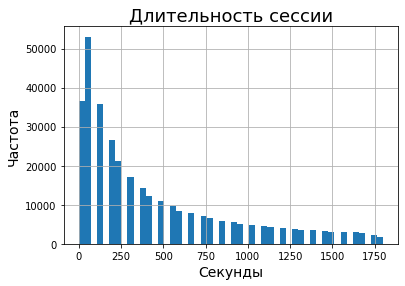


Самое частое значение: 60 секунд


In [15]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print(visits['duration'].describe())

plt.xlabel('Секунды', fontsize = 14)
plt.ylabel('Частота', fontsize = 14)
plt.title('Длительность сессии', fontsize = 18)
visits['duration'].hist(bins = 50, range = (0, 1800))
plt.show()

print(f'\nСамое частое значение: {int(visits["duration"].mode())} секунд')

Хоть в среднем пользователи проводят на сайте около 10 минут, но на эту цифру не стоит опираться, так как распределение не является нормальным. 

Чаще всего встречается значение в 60 секунд. Неужели сайт такой удобный, что фильм "Gone in 60 seconds" был снят именно про пользователей Яндекс.Афиши, или этим пользователям что-то не нравится, раз они так быстро уходят?

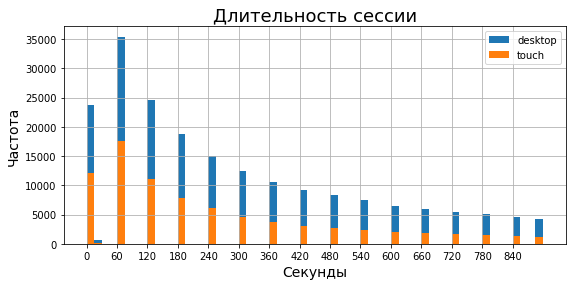

In [16]:
plt.figure(figsize = (9, 4))
plt.xlabel('Секунды', fontsize = 14)
plt.xticks(np.arange(0, 900, step = 60))
plt.ylabel('Частота', fontsize = 14)
plt.title('Длительность сессии', fontsize = 18)

visits_desktop = visits[visits['device'] == 'desktop']['duration']
visits_desktop.hist(bins = 60, range = (0, 900), label = 'desktop')

visits_touch = visits[visits['device'] == 'touch']['duration']
visits_touch.hist(bins = 60, range = (0, 900), label = 'touch')
plt.legend()
plt.show()

На взгляд распределения для компьютеров и для мобильных (сенсорных) устройств одинаковые, проверим это с помощью маетодов статистики.

**Нулевая гипотеза**: средняя продолжительность сессии на десктопах и на сенсорных устройствах одинакова.

**Альтернативная гипотеза**: средная продолжительность различается.

In [17]:
d_d = (visits_desktop.std() ** 2).round(1)
d_t = (visits_touch.std() ** 2).round(1)

print('Дисперсия сессии desktop:', d_d)
print('Дисперсия сессии touch', d_t)

Дисперсия сессии desktop: 1191471.8
Дисперсия сессии touch 566303.7


Нельзя говорить о равенстве дисперсий, поэтому параметр `equal_var` ставим False

In [18]:
alpha = 0.05

results = st.ttest_ind(visits_desktop, visits_touch, equal_var = False)

print('p-значение:', results.pvalue.round(3))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, различия статистически значимы')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 0.0
Отвергаем нулевую гипотезу, различия статистически значимы


Средняя длительность различна, проверим с каких устройств клиенты в среднем дольше находятся на сайте.

In [19]:
print('Средняя длительность на desktop:', visits_desktop.mean().round(1))
print('Средняя длительность на touch:', visits_touch.mean().round(1))

Средняя длительность на desktop: 703.9
Средняя длительность на touch: 479.6


Всё-таки получается, что на сенсорных устройствах люди быстрее уходят с сайта. Возможно, что приложение/мобильная версия не очень удобна, а может и наоборот - заказ оформляется в 2 клика. Нужно провести дополнительное исследование поведения пользователей с момента захода до момента заказа.

#### Как часто люди возвращаются? Retention rate

In [20]:
visits.groupby('uid').agg({'start_ts': 'count'}).describe()

,start_ts
count,"228,169.00"
mean,1.58
std,4.65
min,1.00
25%,1.00
50%,1.00
75%,1.00
max,893.00


К сожалению, 75% клиентов за год заходили лишь 1 раз и не возвращались. Хотя есть и фанат сервиса, который заходил на сайт 893 раза!

In [21]:
first_ts = visits.groupby(['uid'])['start_ts'].min()
first_ts.name = 'first_ts'
visits = visits.join(first_ts, on = 'uid')
visits['first_date'] = visits['first_ts'].dt.date

In [22]:
visits['first_visit_month'] = visits['first_date'].astype('datetime64[M]')
visits['visit_month'] = visits['date'].astype('datetime64[M]')

In [23]:
visits['lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['lifetime'] = visits['lifetime'] / np.timedelta64(1,'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

In [24]:
cohorts = (visits
           .groupby(['first_visit_month','lifetime'])
           .agg({'uid':'nunique'}).reset_index()
          )

In [25]:
cohort_users = cohorts[cohorts['lifetime'] == 0][['first_visit_month','uid']]
cohort_users = cohort_users.rename(columns = {'uid': 'cohort_users'})
cohorts = cohorts.merge(cohort_users, on = 'first_visit_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

In [26]:
ret_rate = cohorts.query('lifetime != 0').pivot_table(index = 'first_visit_month', 
                                      columns = 'lifetime', 
                                      values = 'retention', 
                                      aggfunc = 'sum')

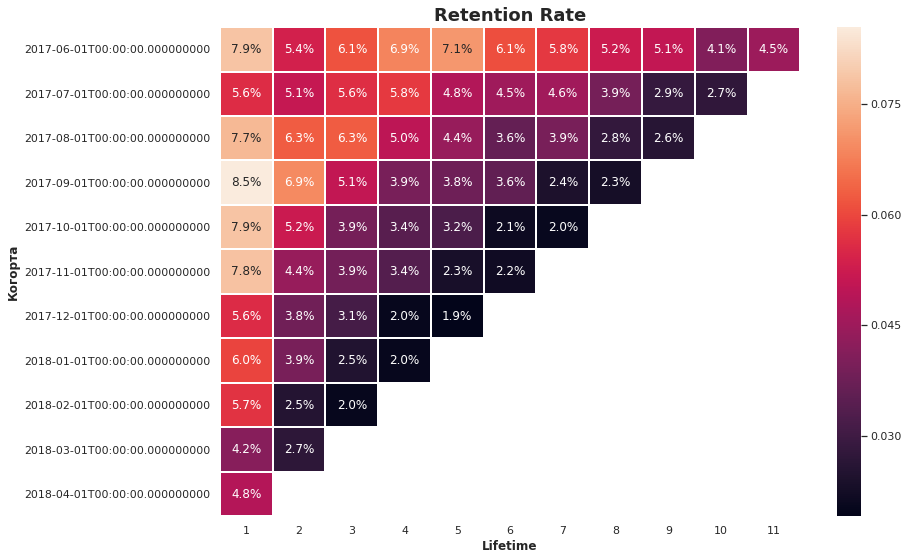

In [27]:
sns.set(style = 'white')
plt.figure(figsize = (13, 9))
plt.title('Retention Rate', fontsize = 18, weight = 'bold')

fig = sns.heatmap(ret_rate, 
            annot = True, fmt = '.1%', 
            linewidths = 1, linecolor = 'white', cmap = 'rocket')
plt.xlabel('Lifetime', fontsize = 12, weight = 'bold')
plt.ylabel('Когорта', fontsize = 12, weight = 'bold')
plt.show(fig)

Действительно, возвращается лишь <10% пользователей, к тому же коэффициент удержания и дальше падает с течением времени. Надо почаще напоминать пользователям о сервисе, например, письмами на почту с новинками и акциями!

#### Когда люди начинают покупать? 

In [28]:
first_visit = (visits
                .sort_values(by = ['uid', 'start_ts'])
                .groupby('uid')
                .agg({'start_ts': 'first', 'source_id': 'first', 'device': 'first'})
               )
first_buy = (orders
                .sort_values(by = ['uid', 'buy_ts'])
                .groupby('uid')
                .agg({'buy_ts': 'first'})
            )
first_buy = first_buy.merge(first_visit, on = 'uid').reset_index()

In [29]:
first_buy['delay'] = ((first_buy['buy_ts'] - first_buy['start_ts']).dt.total_seconds() / 60)
display(first_buy[['delay']].describe())

,delay
count,"36,523.00"
mean,"24,340.18"
std,"67,784.77"
min,0.00
25%,4.00
50%,16.00
75%,"2,897.00"
max,"523,144.00"


50% клиентов завершает заказ через 16 минут после первого захода на сайт. Как говорится "not great not terrible". Есть выбивающиеся значения, которые получились из-за того, что люди делали заказы через полгода с первого попадания на сайт.

Можно также проанализировать какое количество времени пользователь тратит на раздумья, а какое именно на оформление и оплату. Тогда можно попробовать оптимизировать процесс заказа, чтобы клиенты быстрее покупали билеты.

#### Сколько раз покупают за период? 

In [30]:
orders['year']  = orders['buy_ts'].dt.year
orders['month'] = orders['buy_ts'].dt.month
orders['week']  = orders['buy_ts'].dt.week
orders['date'] = orders['buy_ts'].dt.date

In [31]:
orders_by_day = orders.groupby('date').agg({'uid': 'count'}).mean()
orders_by_week = orders.groupby(['year', 'week']).agg({'uid': 'count'}).mean()
orders_by_month = orders.groupby(['year', 'month']).agg({'uid': 'count'}).mean()

print('Покупок в день:', int(orders_by_day))
print('Покупок в неделю:', int(orders_by_week))
print('Покупок в месяц:', int(orders_by_month))

Покупок в день: 138
Покупок в неделю: 951
Покупок в месяц: 3878


#### Какой средний чек?

In [32]:
mean_revenue = orders['revenue'].sum() / orders['uid'].nunique()
print('Средний чек по всем пользователям:', mean_revenue.round(2))

Средний чек по всем пользователям: 6.9


Рассчитаем средний чек в момент жизни каждой когорты

In [33]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_order = orders.groupby('uid')['order_month'].min()
first_order.name = 'first_order_date'
orders = orders.merge(first_order, on = 'uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

In [34]:
order_cohorts = (orders
                 .groupby(['first_order_month', 'order_month'])
                 .agg({'revenue': 'sum', 'uid': 'nunique'})
                )
order_cohorts['revenue_per_user'] = order_cohorts['revenue'] / order_cohorts['uid']
order_cohorts = order_cohorts.reset_index()
order_cohorts['lifetime'] = ((order_cohorts['order_month'] - order_cohorts['first_order_month']) 
                             / np.timedelta64(1, 'M')) \
                             .round().astype('int')
orders_pivot = order_cohorts.pivot_table(index = 'first_order_month', 
                                  columns = 'lifetime', 
                                  values = 'revenue_per_user')

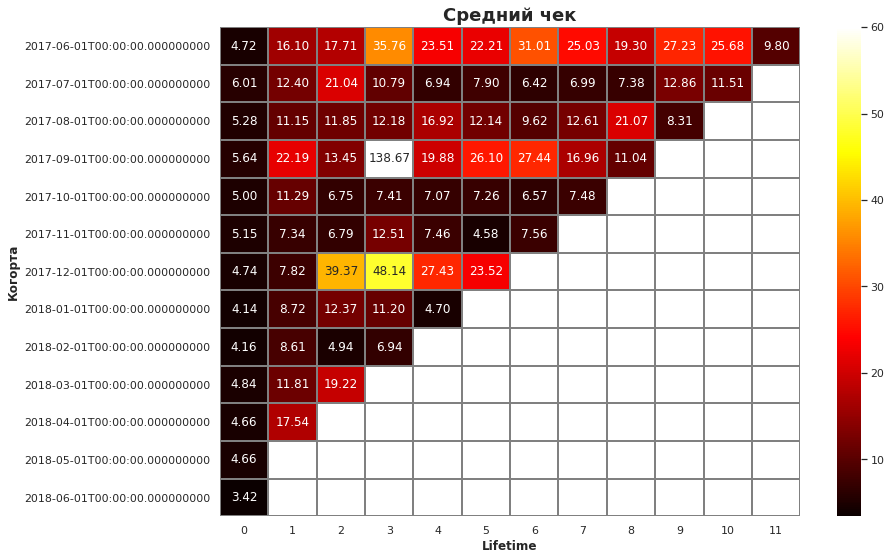

In [53]:
sns.set(style = 'white')
plt.figure(figsize = (13, 9))
plt.title('Средний чек', fontsize = 18, weight = 'bold')

fig = sns.heatmap(orders_pivot, 
            annot = True, fmt = '.2f', 
            linewidths = 1, linecolor = 'grey', cmap = 'hot', vmax = 60)
plt.xlabel('Lifetime', fontsize = 12, weight = 'bold')
plt.ylabel('Когорта', fontsize = 12, weight = 'bold')
plt.show(fig)

На второй месяц жизни все когорты показывают больший средний чек, а дальше кто-то наращивает его, а кто-то топчется на одном месте. 

Очень сильно выделяется сентябрьская когорта в декабре. Моё предположение: в сентябре привлекли много пользователей с детьми, которые в последствие стали покупать билеты на детские новогодние представления.

#### Сколько денег приносят? (LTV) 

In [36]:
cohort_sizes = (first_order
                .reset_index()
                .groupby('first_order_date')
                .agg({'uid': 'nunique'})
                .reset_index()
               )
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [37]:
order_cohorts = pd.merge(order_cohorts, cohort_sizes, on = 'first_order_month')
order_cohorts['ltv'] = order_cohorts['revenue'] / order_cohorts['n_buyers']

orders_ltv_pivot = (order_cohorts
                    .pivot_table(index = 'first_order_month', 
                                 columns = 'lifetime', 
                                 values = 'ltv', 
                                 aggfunc = 'mean')
                    .cumsum(axis=1)
                    .round(2)
                   )

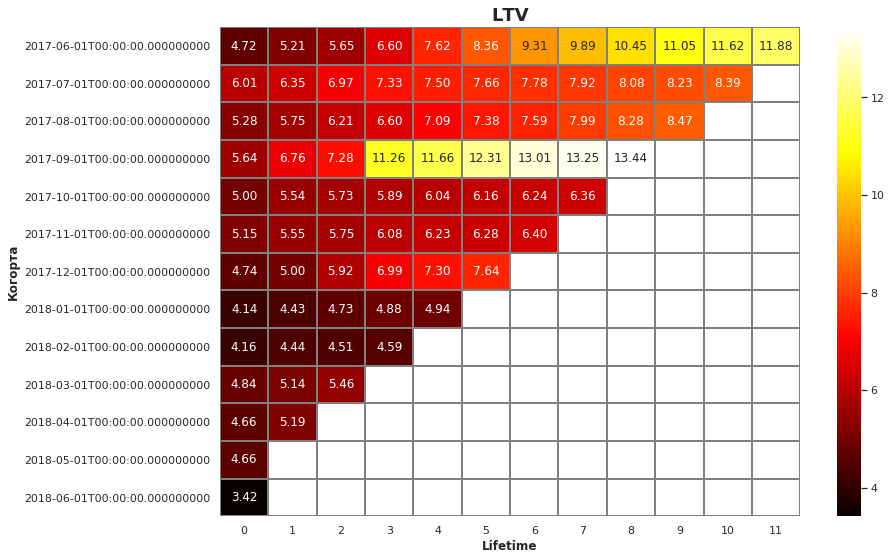

In [38]:
sns.set(style = 'white')
plt.figure(figsize = (13, 9))
plt.title('LTV', fontsize = 18, weight = 'bold')

fig = sns.heatmap(orders_ltv_pivot, 
            annot = True, fmt = '.2f', 
            linewidths = 1, linecolor = 'grey', cmap = 'hot')
plt.xlabel('Lifetime', fontsize = 12, weight = 'bold')
plt.ylabel('Когорта', fontsize = 12, weight = 'bold')
plt.show(fig)

LTV, начиная с 1 месяца "жизни", сильно падает у всех когорт. Плохо ли это? Не узнаем, пока не сравним с затратами CAC и не посчитаем ROMI.

#### Сколько денег потратили? Всего / на каждый источник / по времени 

In [39]:
print('Всего потратили на маркетинг:', costs['costs'].sum())

Всего потратили на маркетинг: 329131.62


In [40]:
source_costs = costs.groupby('source_id').agg({'costs': 'sum'})
print('Всего потратили на каждый источник:')
display(source_costs)

Всего потратили на каждый источник:


,costs
source_id,
1,"20,833.27"
2,"42,806.04"
3,"141,321.63"
4,"61,073.60"
5,"51,757.10"
9,"5,517.49"
10,"5,822.49"


In [41]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_month = costs.groupby('month').agg({'costs': 'sum'}).reset_index()

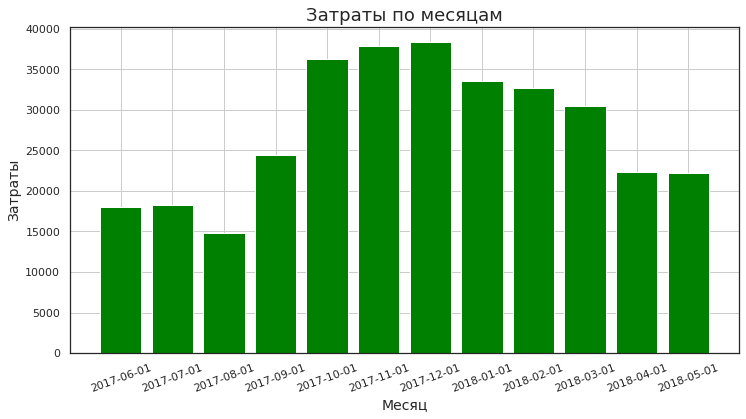

In [42]:
plt.figure(figsize = (12, 6))
plt.ylabel('Затраты', fontsize = 14)
plt.xlabel('Месяц', fontsize = 14)
plt.xticks(rotation = 20)
plt.title('Затраты по месяцам', fontsize = 18)
plt.bar(costs_month['month'].astype('str'), costs_month['costs'], color = 'green', align = 'center')
plt.grid()
plt.show()

В сентябре в первый раз сильно увеличили затраты на маркетинг, и это принесло свои плоды - именно эта когорта показывает лучшие результаты по среднему чеку и LTV. Дальше затраты выросли еще больше, но такого сильного эффекта уже не дали, а с апреля затраты сильно снизились, но последствия этого пока оценить нельзя.

#### Сколько стоило привлечение одного покупателя из каждого источника?

In [43]:
source_orders = first_buy.groupby('source_id').agg({'uid': 'nunique'})
costs_source_pivot = pd.merge(source_orders, source_costs, on = 'source_id')
costs_source_pivot.columns = ['n_users', 'costs']

In [44]:
costs_source_pivot['cac'] = costs_source_pivot['costs'] / costs_source_pivot['n_users']
costs_source_pivot

,n_users,costs,cac
source_id,,,
1,2899,"20,833.27",7.19
2,3506,"42,806.04",12.21
3,10473,"141,321.63",13.49
4,10296,"61,073.60",5.93
5,6931,"51,757.10",7.47
9,1088,"5,517.49",5.07
10,1329,"5,822.49",4.38


CAC посчитан, можно считать окупаемость.

#### На сколько окупились расходы? (ROMI) 

In [45]:
roi_report = pd.merge(order_cohorts, costs_month, left_on = 'first_order_month', right_on = 'month')
roi_report['cac'] = roi_report['costs'] / roi_report['n_buyers']
roi_report['romi'] = roi_report['ltv'] / roi_report['cac']

costs_roi_pivot = roi_report.pivot_table(index = 'first_order_month', 
                                columns = 'lifetime', 
                                values = 'romi', aggfunc = 'mean')
costs_roi_pivot = costs_roi_pivot.cumsum(axis = 1).round(2)

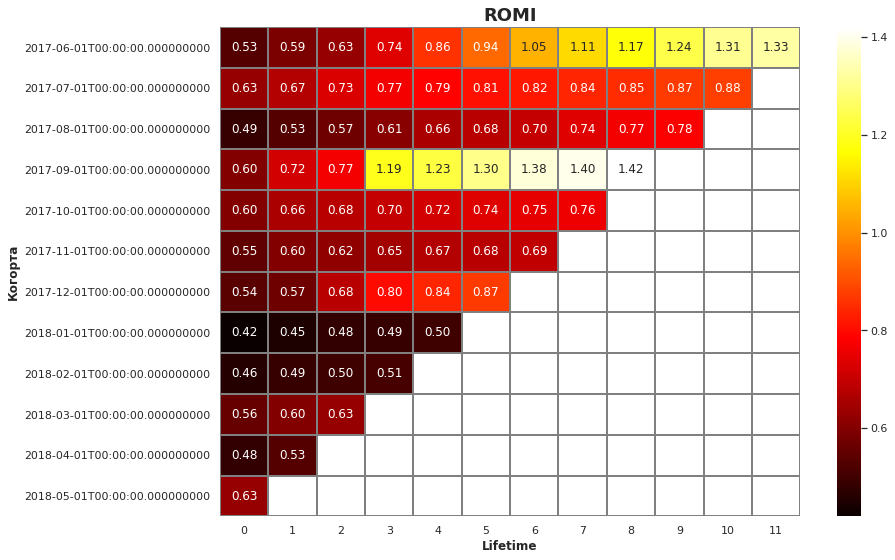

In [46]:
sns.set(style = 'white')
plt.figure(figsize = (13, 9))
plt.title('ROMI', fontsize = 18, weight = 'bold')

fig = sns.heatmap(costs_roi_pivot, 
            annot = True, fmt = '.2f', 
            linewidths = 1, linecolor = 'grey', cmap = 'hot')
plt.xlabel('Lifetime', fontsize = 12, weight = 'bold')
plt.ylabel('Когорта', fontsize = 12, weight = 'bold')
plt.show(fig)

Из всех когорт окупились лишь майская (на 6 месяце жизни) и сентябрьская (на 4 месяце). Остальные когорты не окупились и очень медленно движутся к этому. Пора что-то менять!

**Вывод шага 3:**

Из метрик полученных на этом шаге видно, что в месяц на сайт заходят 23 тысячи уникальных пользователей, из которых возвращается в следующий раз меньше 10%.

А из тех, кто остался, половина покупает что-то в течение 16 минут с первого захода на сайт. Общий средний чек - 6.9 у.е., но какие-то когорты наращивают его со временем, а какие-то остаются при этом же значении.

Окупаемость достаточно плохая: лишь 2 когорты смогли окупиться, а остальные медленно наращивают темп. 

### Шаг 4. Графики 

- ltv по устройствам/источникам

In [47]:
for device in visits['device'].unique():
    ids = visits[visits['device'] == device]['uid'].unique()
    orders.loc[orders['uid'].isin(ids), 'device'] = device
    
for source in visits['source_id'].unique():
    ids = visits[visits['source_id'] == source]['uid'].unique()
    orders.loc[orders['uid'].isin(ids), 'source_id'] = source

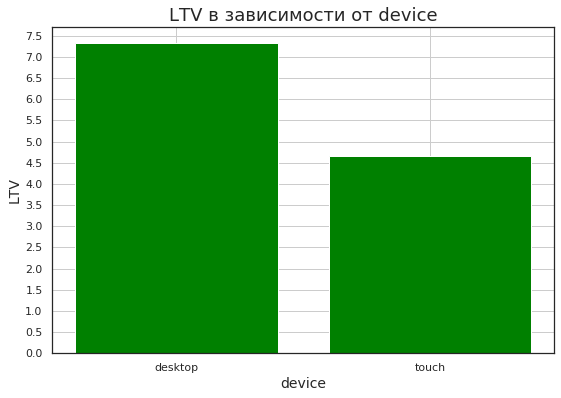

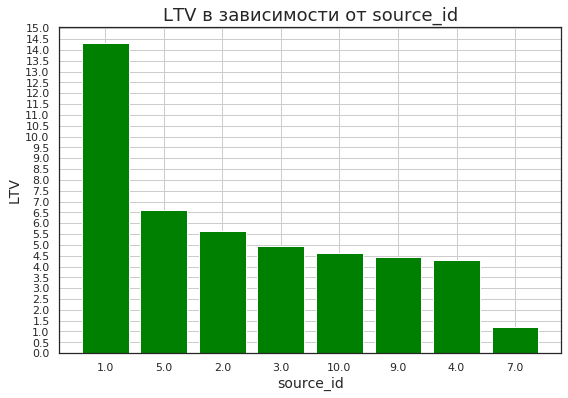

In [48]:
for column in ['device', 'source_id']:
    ltv = orders.groupby(column).agg({'revenue': 'sum', 'uid': 'nunique'}).reset_index()
    ltv['ltv'] = ltv['revenue'] / ltv['uid']
    ltv = ltv.sort_values(by = 'ltv', ascending = False)
    plt.figure(figsize = (9, 6))
    plt.ylabel('LTV', fontsize = 14)
    plt.xlabel(column, fontsize = 14)
    plt.yticks(ticks = np.arange(0, ltv['ltv'].max() + 1, step = 0.5))
    plt.title('LTV в зависимости от ' + column, fontsize = 18)
    plt.bar(ltv[column].astype(str), ltv['ltv'], color = 'green', align = 'center')
    plt.grid()
    plt.show()

- romi по источникам

In [49]:
romi = ltv.merge(source_costs, on = 'source_id')
romi['cac'] = romi['costs'] / romi['uid']
romi['romi'] = romi['ltv'] / romi['cac']

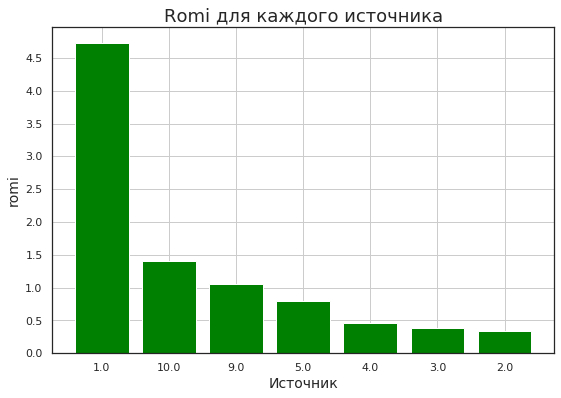

In [50]:
romi = romi.sort_values(by = 'romi', ascending = False)
plt.figure(figsize = (9, 6))
plt.ylabel('romi', fontsize = 14)
plt.xlabel('Источник', fontsize = 14)
plt.yticks(ticks = np.arange(0, romi['romi'].max() + 1, step = 0.5))
plt.title('Romi для каждого источника', fontsize = 18)
plt.bar(romi['source_id'].astype(str), romi['romi'], color = 'green', align = 'center')
plt.grid()
plt.show()

**Вывод шага 4:**

LTV выше у тех пользователей, которые пользуются десктопами для заказа. Но так как у нас нет данных о том, сколько стоит привлечение пользователя для каждой платформы, то мы не можем посчитать окупаемость. 

А вот для источников (почти всех) у нас имеются данные и по расходам и по доходам. По этим данным получается, что окупились только 3 источника: 1, 9 и 10. Идеальное соотношение показателя LTV и CAC 3 к 1. "Идеально" окупаются затраты лишь на 1 источник.

### Шаг 5. Рекомендация

Более выгодно вкладываться именно в `desktop` устройства, так как у них LTV выше примерно в 1.5 раза. Но возможно, можно улучшить мобильное приложение и мобильную версию сайта, чтобы доходы от сенсорных устройств вышли на тот же уровень (а может быть и выше).

Идеальный рекламный источник - `1`, его ROMI больше 4.5. К тому же хорошие результаты показывают источники `9` и `10`, их ROMI больше единицы.

Стоит вспомнить и ориентироваться на *сентябрьскую* стратегию, так как эта когорта имеет самый высокий средний чек и окупилась уже на 4 месяц, хотя маркетинговые затраты на неё были не самыми большими.

### Шаг 6. Общий вывод

1. Были проанализированные данные Яндекс.Афиши о посещениях, покупках и затратах на рекламу. 
2. Данные оптимизированы, приведены к нужным типам и проверены на корректность.
3. Посчитаны метрики для продуктов, продаж и маркетинга: 
    - retention rate, 
    - ltv, 
    - cac, 
    - romi и т.д.
4. Построены графики метрик ltv и romi по устройствам и по рекламным источникам.
5. Сформулирована рекомендация для маркетологов:
    - стоит ориентироваться на пользователей компьютеров и ноутбуков, у них выше окупаемость
    - и лучший рекламный источник - 1, доход от него в 4.5 раза больше расхода!